In [ ]:
import argparse
import random
import sys
import yaml
from os.path import join, exists
import os
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import tensorflow as tf

from mlmicrophysics.metrics import heidke_skill_score, peirce_skill_score, hellinger_distance, root_mean_squared_error, r2_corr
from mlmicrophysics.models import DenseNeuralNetwork
from mlmicrophysics.data import subset_data_files_by_date, assemble_data_files


# set random seed
seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [3]:
# define data parameters

data_path = "ncar-aiml-data-commons/microphysics"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    out_path = "/content/gdrive/My Drive/micro_models/base"
else:
    out_path = "./micro_models/base/"
if not exists(out_path):
    os.makedirs(out_path)
subsample = 0.1
input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qrtend_TAU", "nctend_TAU", "nrtend_TAU"]

subset_data = {"train_date_start" : 0,
               "train_date_end" : 11000,
               "test_date_start" : 11100,
               "test_date_end" : 17500}

input_scaler = StandardScaler()
input_transforms = {"QC_TAU_in" : "log10_transform",
                    "NC_TAU_in" : "log10_transform",
                    "QR_TAU_in" : "log10_transform",
                    "NR_TAU_in" : "log10_transform"}

output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
                                   0: ["==", 0, "zero_transform", "None"],
                                   1: [">", 0, "log10_transform", "StandardScaler"]}}


In [4]:
# Load data from disk or cloud
# Separate input, output and meta data
# Split into training, validation, and test sets

print("Subsetting file paths by train, validation, and test")
train_files, val_files, test_files = subset_data_files_by_date(data_path, **subset_data)

print("\nLoading training data")
scaled_input_train, \
labels_train, \
transformed_out_train, \
scaled_out_train, \
output_scalers, \
meta_train = assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                 output_transforms, input_scaler, subsample=subsample)

print("\nLoading testing data")
scaled_input_test, \
labels_test, \
transformed_out_test, \
scaled_out_test, \
output_scalers_test, \
meta_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                output_transforms, input_scaler, output_scalers=output_scalers,
                                train=False, subsample=subsample)


Subsetting file paths by train, validation, and test
File times:
 [    0   100   200   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300
  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500
  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700
  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900
  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900
 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100
 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300
 14400 14500 14600 14700 14800 14900 15000 15100 15200 153

In [5]:
# save meta data, input scalers, and output scalers
    
meta_test.to_csv(join(out_path, "meta_test.csv"), index_label="index")

input_scaler_df = pd.DataFrame({"mean": input_scaler.mean_, "scale": input_scaler.scale_},
                               index=input_cols)
input_scaler_df.to_csv(join(out_path, "input_scale_values.csv"), index_label="input")

out_scales_list = []
for var in output_scalers.keys():
    for out_class in output_scalers[var].keys():
        if output_scalers[var][out_class] is not None:
            out_scales_list.append(pd.DataFrame({"mean": output_scalers[var][out_class].mean_,
                                                 "scale": output_scalers[var][out_class].scale_},
                                                index=[var + "_" + str(out_class)]))
out_scales_df = pd.concat(out_scales_list)
out_scales_df.to_csv(join(out_path, "output_scale_values.csv"),
                     index_label="output")
out_scales_df

,mean,scale
qrtend_TAU_1,-11.190049,2.089005
nctend_TAU_1,-0.172256,2.584713
nrtend_TAU_-1,-3.434289,2.271458
nrtend_TAU_1,-2.084925,1.801713


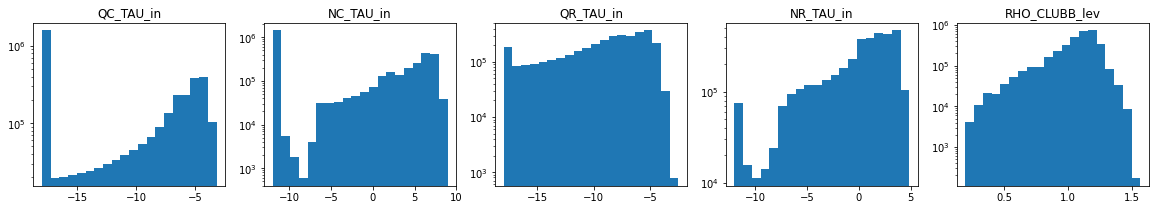

In [6]:
# Histograms of original training input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(transformed_input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

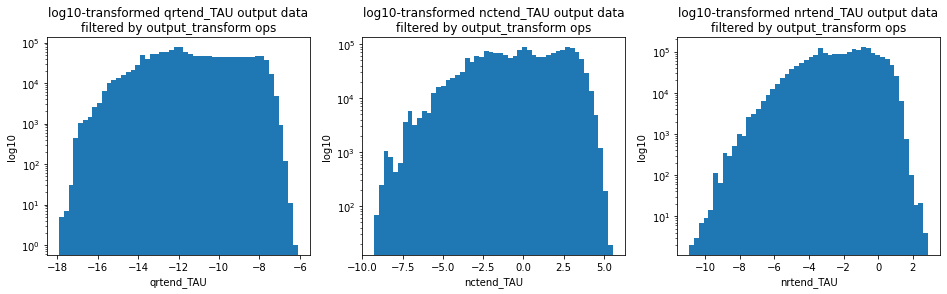

In [7]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
for output_col, ax in zip(output_cols, (ax1, ax2, ax3)):
    original_out_train_nc = np.zeros(scaled_out_train.shape[0])
    original_out_train_nc[labels_train[output_col] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == 1, [output_col]]).ravel()
    original_out_train_nc[labels_train[output_col] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == -1, [output_col]]).ravel()
    ax.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
    ax.set_xlabel(output_col)
    ax.set_ylabel('log10')
    ax.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
    ax.set_yscale('log')


In [8]:
# Inverse transform and scaling of scaled train data

original_out_train_nr = np.zeros(scaled_out_train.shape[0])
original_out_train_nr[labels_train["nrtend_TAU"] == 1] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == 1, ["nrtend_TAU"]]).ravel()
original_out_train_nr[labels_train["nrtend_TAU"] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == -1, ["nrtend_TAU"]]).ravel()


original_out_train_nc = np.zeros(scaled_out_train.shape[0])
original_out_train_nc[labels_train["nctend_TAU"] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nctend_TAU"] == 1, ["nctend_TAU"]]).ravel()

original_out_train_qr = np.zeros(scaled_out_train.shape[0])
original_out_train_qr[labels_train["qrtend_TAU"] == 1] = 10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, ["qrtend_TAU"]]).ravel()


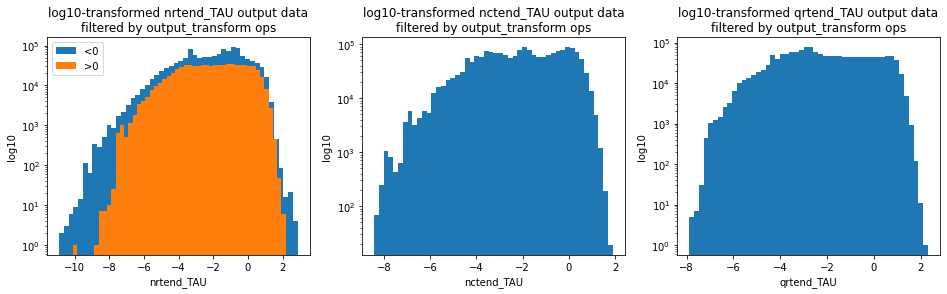

In [9]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.hist(np.log10(-original_out_train_nr[original_out_train_nr < 0]), bins=50, label="<0")
ax1.hist(np.log10(original_out_train_nr[original_out_train_nr > 0]), bins=50, label=">0")
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
ax2.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
ax3.hist(np.log10(original_out_train_qr[original_out_train_qr > 0]), bins=50)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()


## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [13]:
# Monday's code goes here
import seaborn as sns

In [14]:
# load and view a single file
fs = s3fs.S3FileSystem(anon=True)
filenames = fs.ls("s3://ncar-aiml-data-commons/microphysics")
fobj = fs.open(filenames[0])
single_file = pd.read_parquet(fobj).set_index('Index')
input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qrtend_TAU", "nctend_TAU", "nrtend_TAU"]
main_file = single_file[input_cols+output_cols]

In [22]:
non_zeros = main_file[(np.abs(main_file['qrtend_TAU']) > 1e-12) &(np.abs(main_file['nctend_TAU']) > 1e-12) & (np.abs(main_file['nrtend_TAU']) > 1e-12)]

In [23]:
non_zeros.describe()

,QC_TAU_in,NC_TAU_in,QR_TAU_in,NR_TAU_in,RHO_CLUBB_lev,qrtend_TAU,nctend_TAU,nrtend_TAU
count,1.112490e+05,1.112490e+05,1.112490e+05,1.112490e+05,111249.000000,1.112490e+05,111249.000000,111249.000000
mean,5.033018e-05,1.720411e+07,3.275836e-05,2.972169e+04,1.107376,8.212813e-09,-2458.548917,-2.568329
std,6.288291e-05,3.215710e+07,8.197937e-05,4.790574e+04,0.152405,1.984323e-08,7767.591732,10.817548
min,0.000000e+00,1.000000e-12,0.000000e+00,1.000000e-12,0.424668,1.000137e-12,-317815.440000,-365.470120
25%,7.198938e-08,7.529893e+01,3.979520e-07,4.308374e+03,1.059491,1.007875e-11,-1716.194000,-0.871958
50%,2.383203e-05,3.582413e+06,3.834844e-06,1.591459e+04,1.139718,2.593558e-10,-189.746110,-0.002934
75%,8.080309e-05,2.203513e+07,2.896328e-05,3.833225e+04,1.201547,6.290193e-09,-2.786532,0.282987
max,6.458532e-04,6.026141e+08,3.984105e-03,1.870064e+06,1.464344,1.045375e-06,-0.010150,57.823082


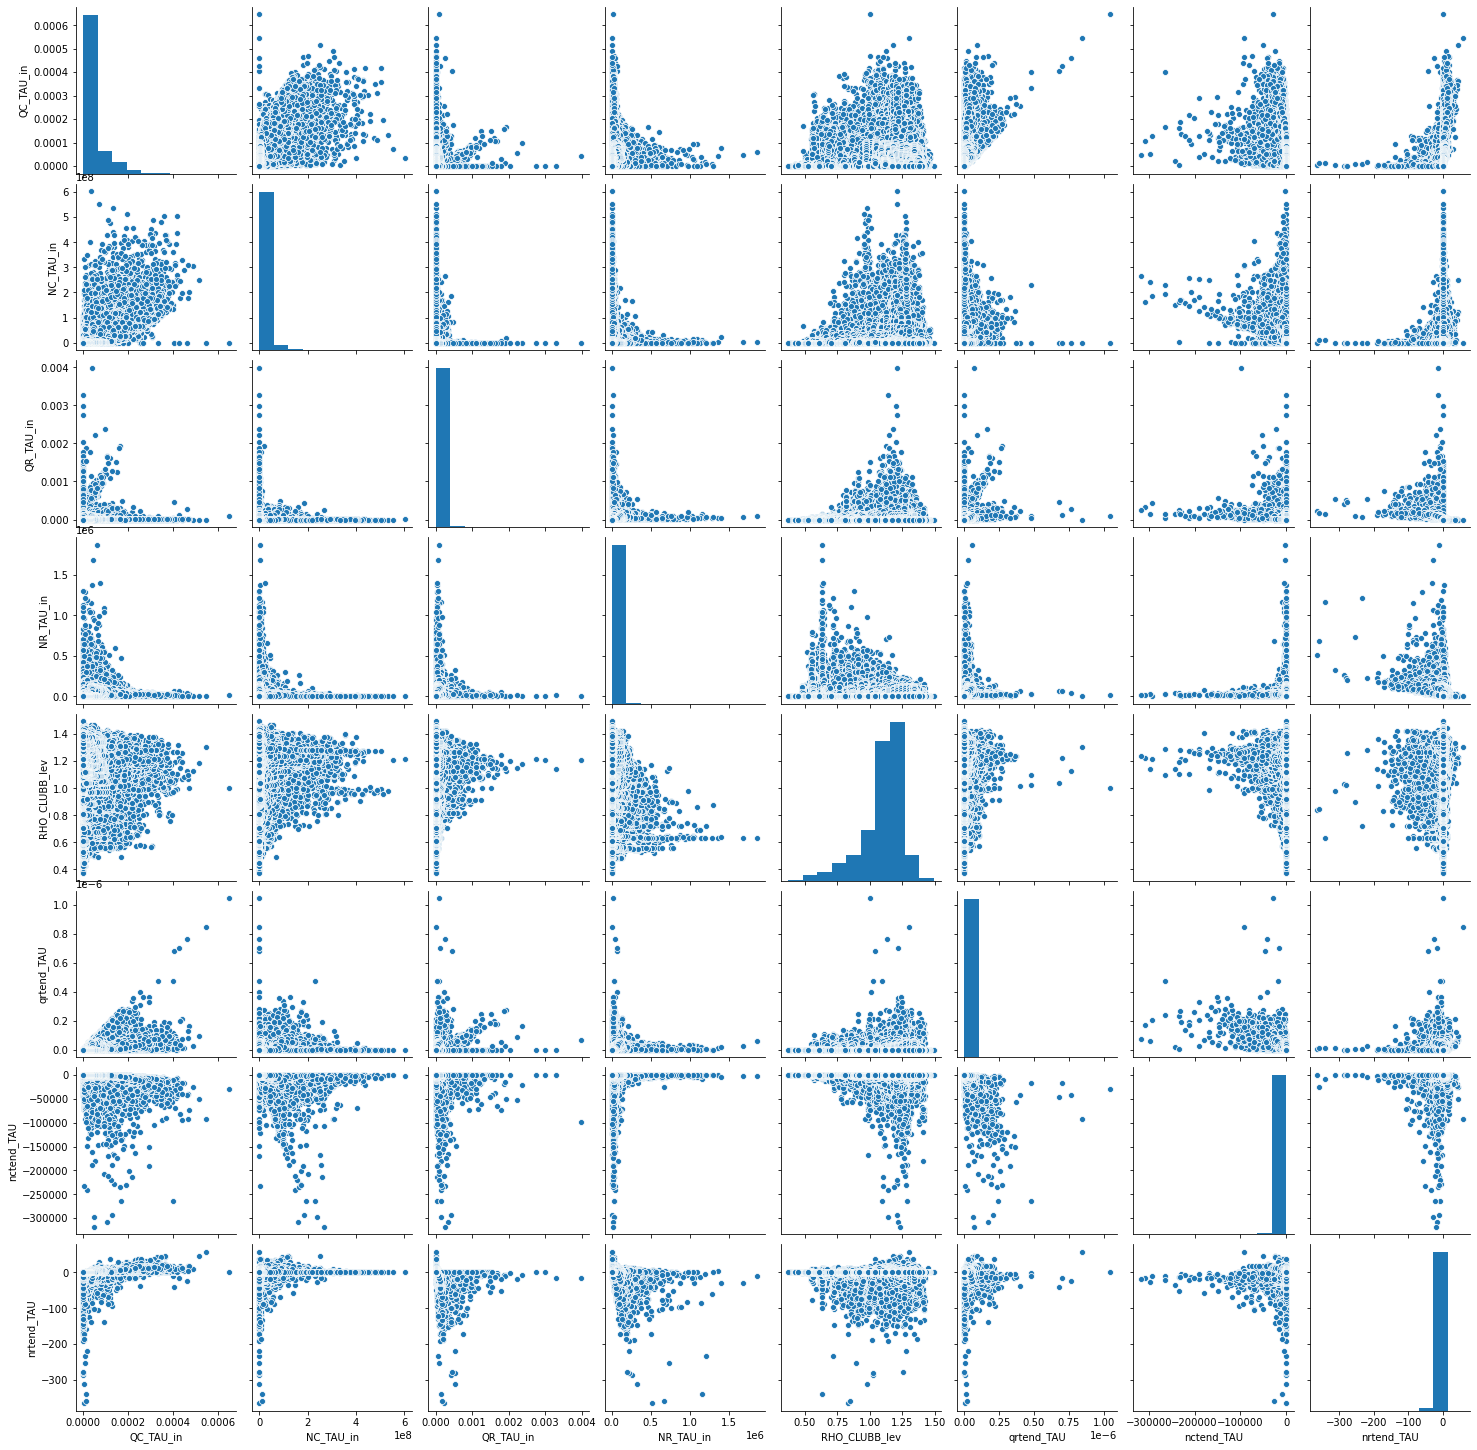

In [17]:
sns.pairplot(non_zeros)

In [269]:
# Standardize 
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler, RobustScaler
from scipy.special import gamma
transform_df = non_zeros.copy()
## Transform QC_TAU_in NC_TAU_in QR_TAU_in NR_TAU_in
for col in ['QR_TAU_in', 'NR_TAU_in', 'qrtend_TAU']:
    qt = StandardScaler()
    transform_df[col] = np.log(transform_df[col]/transform_df[col].max()+1e-12)
    transform_df[col] = qt.fit_transform(transform_df[col].values.reshape(-1,1))

for col in ['QC_TAU_in', 'NC_TAU_in']:
    qt = StandardScaler()
    transform_df[col] = transform_df[col]/transform_df[col].std()
    transform_df[col] = -np.log(1-0.025*transform_df[col])
#     transform_df[col] = qt.fit_transform(transform_df[col].values.reshape(-1,1))

qt = StandardScaler()
transform_df['RHO_CLUBB_lev'] = qt.fit_transform(transform_df['RHO_CLUBB_lev'].values.reshape(-1,1))
for col in ['qrtend_TAU', "nctend_TAU", "nrtend_TAU"]:
    qt = QuantileTransformer(output_distribution='normal')
    transform_df[col] = qt.fit_transform(transform_df[col].values.reshape(-1,1))


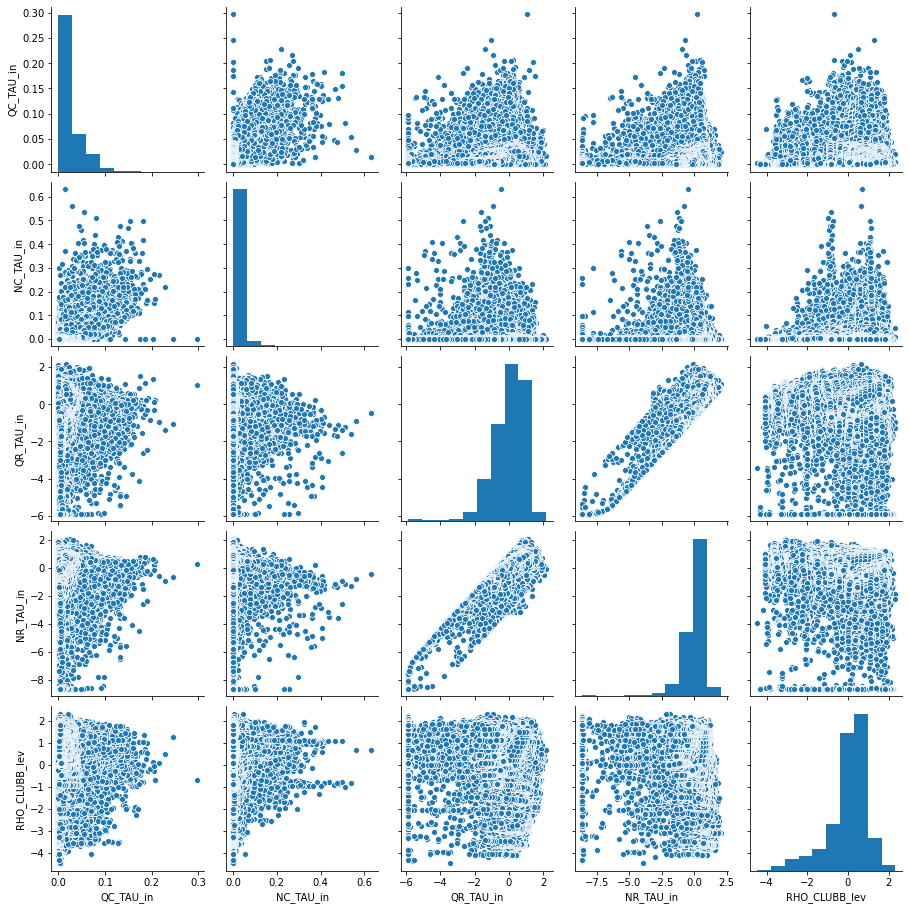

In [270]:
sns.pairplot(transform_df, vars=input_cols)

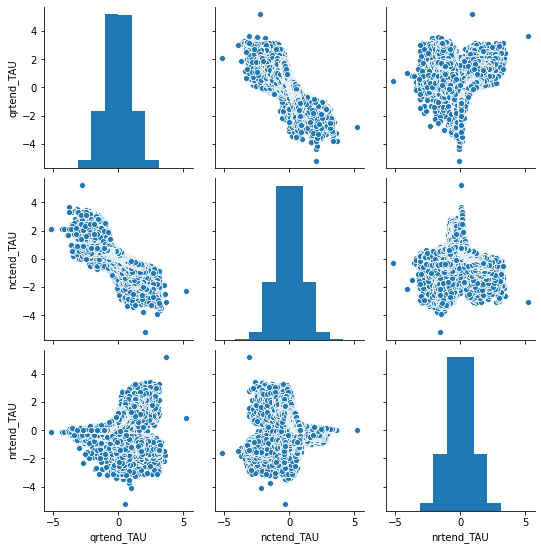

In [271]:
sns.pairplot(transform_df, vars=output_cols)

<Figure size 1440x720 with 0 Axes>

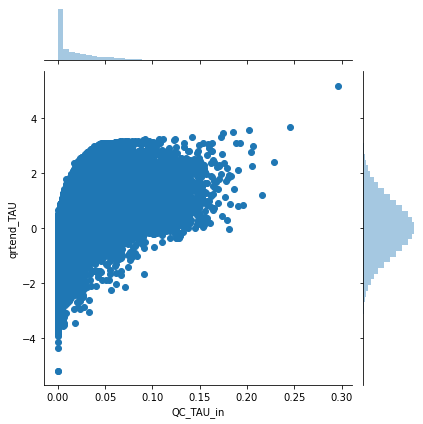

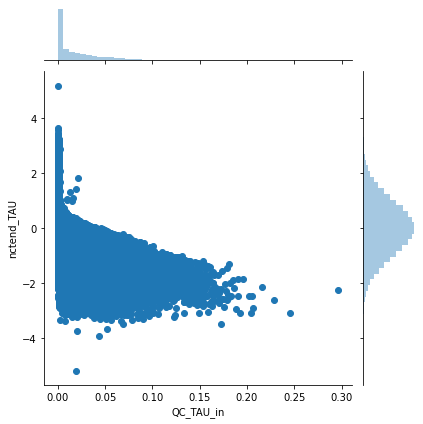

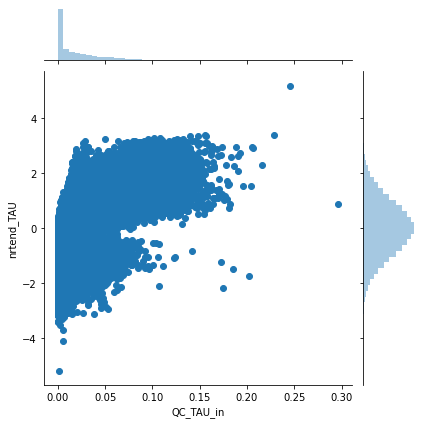

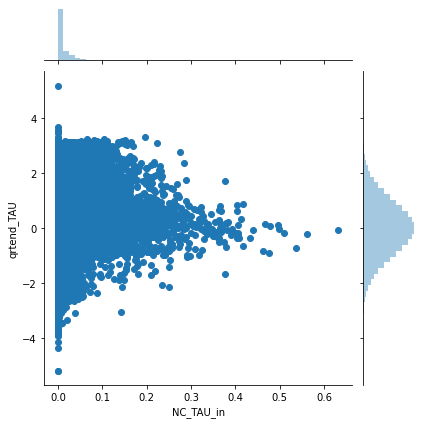

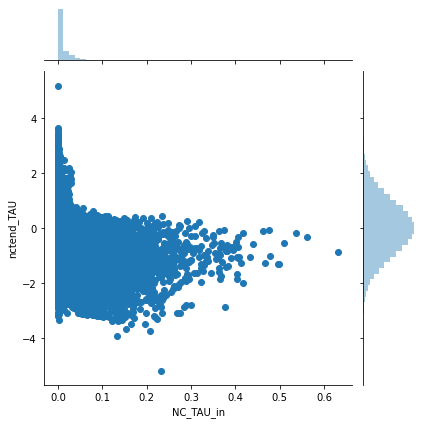

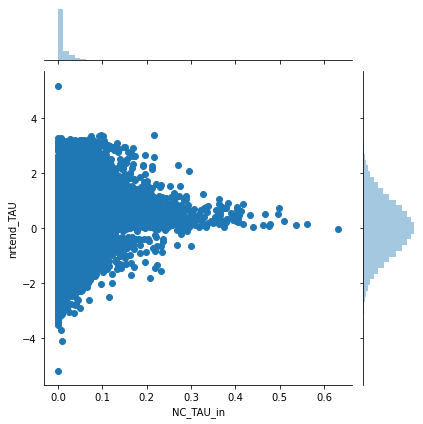

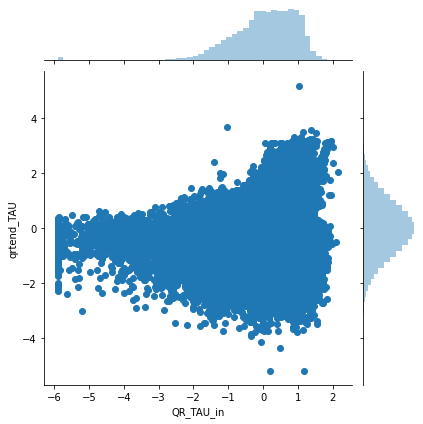

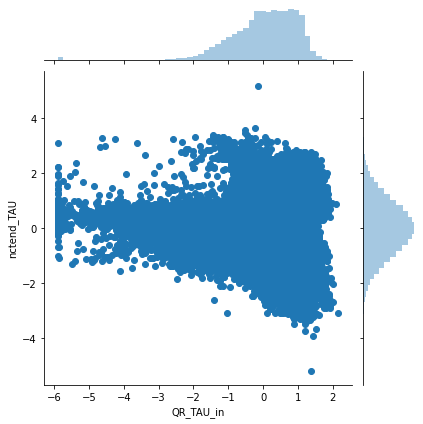

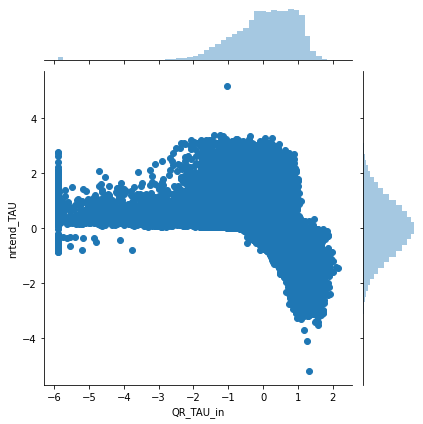

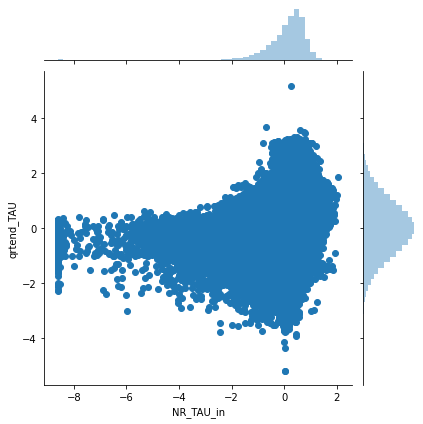

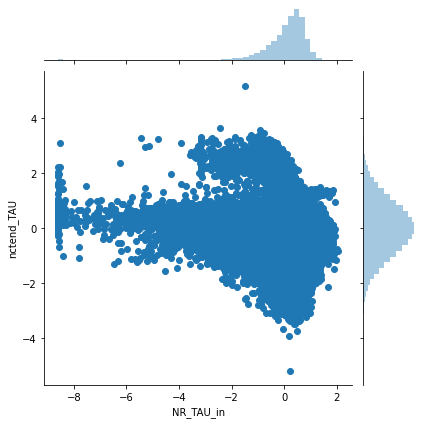

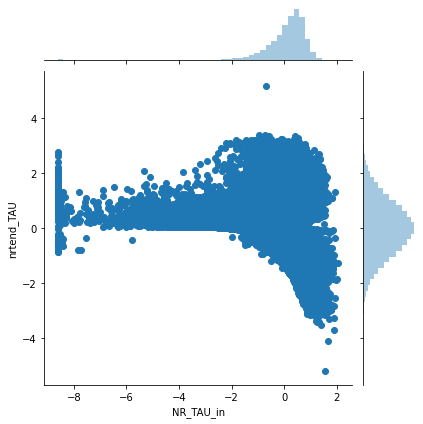

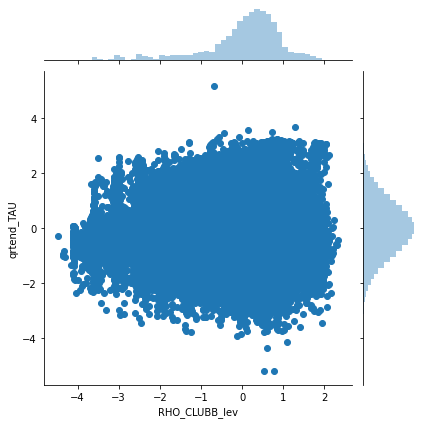

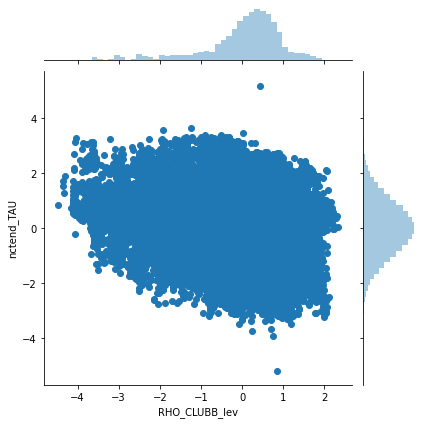

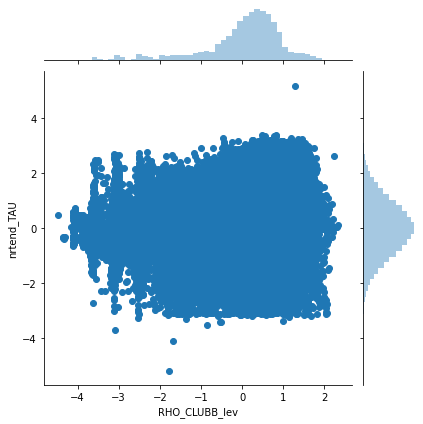

In [272]:
fig = plt.figure(figsize=(20,10))
for j in range(5):
    for i in range(3):
        sns.jointplot(x=input_cols[j], y = output_cols[i], data = transform_df)

In [ ]:
#Let's use a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
regr = LinearRegression()
regr.fit(scaled_input_train,scaled_out_train)
predictions = regr.predict(scaled_input_test)
for i in range(scaled_out_test.shape[1]):
    corr, _ = pearsonr(predictions[:,i], scaled_out_test.iloc[:,i])
    rmse = mean_squared_error(scaled_out_test.iloc[:,i], predictions[:,i])
    print("RMSE: {:.2f}".format(rmse))
    plt.scatter(scaled_out_test.iloc[:,i], predictions[:,i])
    plt.title(output_cols[i])
    plt.xlabel('Scaled Test Output')
    plt.ylabel('Predicted Test Output')
    plt.show()